# Ballistic Deposition with Relaxation
## Packages

In [2]:
include("../BallisticDeposition.jl")
using Plots, ColorSchemes, LaTeXStrings, Statistics, DelimitedFiles
import PyPlot as plt

## Configurations

In [3]:
figpath = "../../fig/ballistic-deposition/"
rcParams = plt.PyDict(plt.matplotlib["rcParams"])
rcParams["text.usetex"] = true

true

## Visualizing the Layers

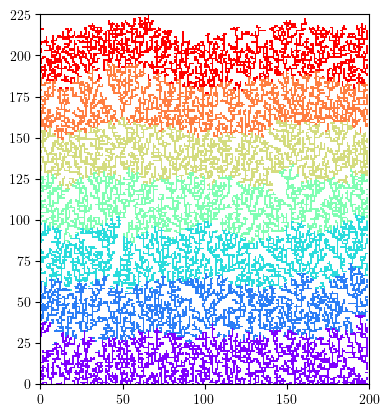

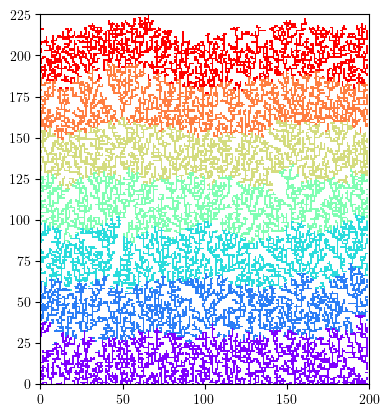

In [3]:
surface = zeros(Integer, 200)
grids = [BallisticDeposition.bdfull!(surface, 3000) for i in 1:7]

fig, ax = plt.subplots()
ax.set_xlim(0, 200)
ax.set_ylim(0, maximum(surface))

rainbow = plt.get_cmap("rainbow")
for i in 7:-1:1
    ax.imshow(grids[i], cmap=plt.ColorMap("cust", vcat([1 1 1 0],
        collect(rainbow((i - 1) / 6))')),  interpolation="nearest")
end

display(fig)
plt.savefig(figpath * "bd-vis.pdf", bbox_inches="tight")

## Means

In [33]:
len, samples = 200, 20

times = collect(Integer, range(100 * len, 100 * len * samples, length=samples))
heights = BallisticDeposition.bdheights(BallisticDeposition.bdeposition!, len, times)
mean_heights = mean(heights, dims=1)'

intercept, slope = hcat(ones(samples), times) \ mean_heights
error = √(sum(x->x^2, mean_heights - slope * times .- intercept) / (samples - 2)
    / sum(x->x^2, times .- mean(times)))
print(slope, ' ', error)

0.010697706578947369 8.963103407269152e-6

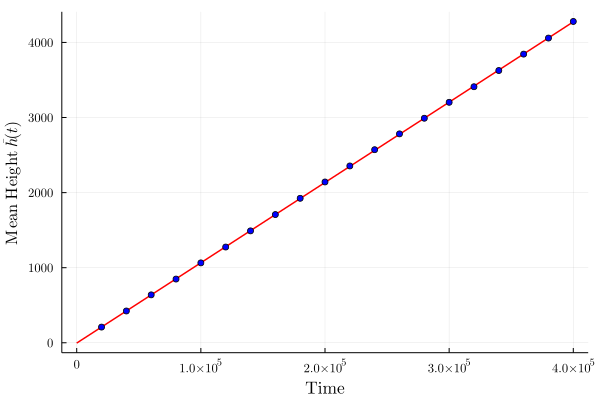

In [34]:
p = plot(x -> slope * x + intercept, 0, maximum(times), color=:red, lw=1.5,
    legend=false, fontfamily="Computer Modern",
    xlabel="Time", ylabel=L"\textrm{Mean \ Height} \ \bar{h}(t)")
scatter!(p, times, mean_heights, color=:blue)

display(p)
savefig(p, figpath * "bd-mean.pdf")

## Roughness

In [25]:
# dictionaries mapping surface length to t_s and w_s for later use
tsdict, wsdict = Dict{Float64, Float64}(), Dict{Float64, Float64}()

(Dict{Float64, Float64}(), Dict{Float64, Float64}())

In [4]:
len, time, samples, runs = 100, 5 * 10^4, 100, 10000
times = [convert(Integer, ceil(ℯ^t)) for t in range(log(5 * len), log(time), length=samples)]

100-element Vector{Int64}:
   500
   524
   549
   575
   603
   631
   661
   693
   726
   760
   797
   835
   874
     ⋮
 29975
 31402
 32897
 34464
 36105
 37824
 39625
 41511
 43488
 45559
 47728
 50001

In [90]:
# generate new data
heights = [BallisticDeposition.bdheights(BallisticDeposition.bdeposition!, len, times) for run in 1:runs]
roughness = mean([std(height, dims=1) for height in heights])'
σroughness = std([std(height, dims=1) for height in heights])'

# save data to file
open("bd-data/bd-$len.txt", "w") do io
    writedlm(io, [times roughness σroughness])
end

In [5]:
# load Data from file
data = readdlm("bd-data/bd-$len.txt")
times, roughness, σroughness = data[:, 1], data[:, 2], data[:, 3]

([500.0, 524.0, 549.0, 575.0, 603.0, 631.0, 661.0, 693.0, 726.0, 760.0  …  32897.0, 34464.0, 36105.0, 37824.0, 39625.0, 41511.0, 43488.0, 45559.0, 47728.0, 50001.0], [2.705971453411961, 2.749957013127772, 2.793701083343947, 2.8352319539546063, 2.879241361263876, 2.9218159426903227, 2.964947699571366, 3.0075980865974716, 3.049804695599959, 3.090711670733027  …  5.29593131383283, 5.301325279905925, 5.299188778292523, 5.310001267514256, 5.316618205090711, 5.2947657998515085, 5.2797866456018205, 5.291020460432942, 5.299594092294395, 5.29366886895526], [0.31169811347112153, 0.3220084648890262, 0.33171200787440797, 0.3404414450599689, 0.3535479427865413, 0.36297173300308294, 0.3752947275284052, 0.3841142491448685, 0.3929273717935122, 0.40325845013734035  …  1.4026846225605336, 1.424798954103388, 1.4261115971791865, 1.4197486818976723, 1.4190137238820504, 1.4308618271343816, 1.4081673195105655, 1.4011813918821312, 1.4122460840195696, 1.4035680603815888])

In [6]:
timelog, roughlog = log.(times), log.(roughness)

r = 1 # coefficient of determination
maxlin = 2 # the last point for the roughness trend line
beta, coeff = undef, undef
while r > 0.998
    maxlin += 1
    beta, coeff = hcat(timelog[1:maxlin], ones(maxlin)) \ roughlog[1:maxlin]
    r = √(1 - sum(x->x^2, roughlog[1:maxlin] - beta * timelog[1:maxlin] .- coeff)
        / sum(x->x^2, roughlog[1:maxlin] .- mean(roughlog[1:maxlin])))
end
println(maxlin)

ϵ = 0 # residuals; we don't use r here because the line is nearly flat
minflat = samples - 1 # the first point for the flat trend line after saturation
flatness, wslog = undef, undef
while ϵ < 0.015
    minflat -= 1
    flatness, wslog = hcat(timelog[minflat:end], ones(samples - minflat + 1)) \ roughlog[minflat:end]
    ϵ = √sum(x->x^2, roughlog[minflat:end] - flatness * timelog[minflat:end] .- wslog)
end
println(minflat)

error = √(sum(x->x^2, roughlog[1:maxlin] - beta * timelog[1:maxlin] .- coeff) / (maxlin - 2)
    / sum(x->x^2, timelog[1:maxlin] .- mean(timelog[1:maxlin])))
print(beta, ' ', error)

41
70
0.2544730097485199 0.002624274401378796

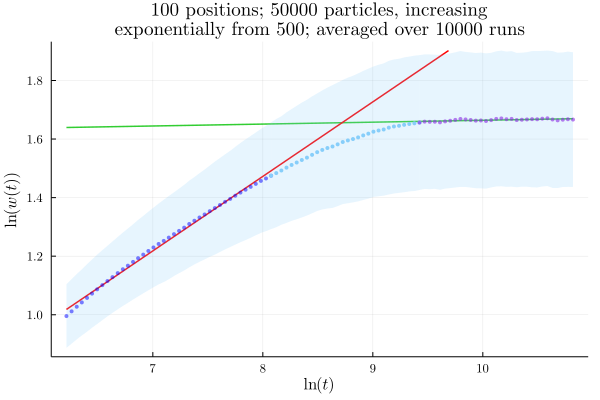

In [8]:
errorbar = σroughness ./ roughness - (σroughness ./ roughness).^2 ./ 2

# plot the trendlines
p = plot(x -> flatness * x + wslog, timelog[1], timelog[end], color=:limegreen, lw=1.5)
plot!(p, x -> beta * x + coeff, timelog[1],
    maximum(roughlog + errorbar .- coeff) / beta, color=:red, lw=1.5,
    xlabel=L"\mathrm{ln}(t)", ylabel=L"\mathrm{ln}(w(t))",
    title="$len positions; $time particles, increasing\n"
    * "exponentially from $(len * 5); averaged over $runs runs",
    legend=false, titlefontsize=12, fontfamily="Computer Modern")

scatter!(p, timelog[1:maxlin], roughlog[1:maxlin], ribbon=errorbar[1:maxlin],
    fillcolor=:lightskyblue, fillalpha=0.2, markercolor=:blue, markeralpha=0.5,
    markersize=2.3, markerstrokewidth=0)
scatter!(p, timelog[maxlin:minflat], roughlog[maxlin:minflat], ribbon=errorbar[maxlin:minflat],
    fillcolor=:lightskyblue, fillalpha=0.2, markercolor=:lightskyblue, markersize=2.3, markerstrokewidth=0)
scatter!(p, timelog[minflat:end], roughlog[minflat:end], ribbon=errorbar[minflat:end],
    fillcolor=:lightskyblue, fillalpha=0.2, markercolor=:blueviolet, markeralpha=0.6,
    markersize=2.3, markerstrokewidth=0)

# savefig(p, figpath * "bd-roughness-$len.pdf")
display(p)


In [123]:
tsdict[len] = ℯ^timelog[minflat]
wsdict[len] = ℯ^wslog
println(tsdict)
println(wsdict)

Dict(50.0 => 2714.9999999999995, 200.0 => 65002.999999999985, 25.0 => 405.99999999999994, 12.0 => 106.99999999999996, 100.0 => 12386.000000000005)
Dict(50.0 => 4.2079606119758095, 200.0 => 6.753158170277365, 25.0 => 2.8443728358565417, 12.0 => 2.428591470857305, 100.0 => 4.948406448090479)


## Saturation

In [124]:
# run after adding all ts and ws to the respective dictionaries
ts = sort(collect(values(tsdict)))
ws = sort(collect(values(wsdict)))
ls = sort(collect(keys(tsdict)))
tslog = log.(ts)
wslog = log.(ws)
lslog = log.(ls)

5-element Vector{Float64}:
 2.4849066497880004
 3.2188758248682006
 3.912023005428146
 4.605170185988092
 5.298317366548036

In [125]:
z, coeffz = hcat(lslog, ones(length(ts))) \ tslog
error = √(sum(x->x^2, tslog - z * lslog .- coeffz) / (length(ts) - 2)
    / sum(x->x^2, lslog .- mean(lslog)))
print(z, ' ', error)

2.3140311493361 0.07223044250295166

In [126]:
alpha, coeffa = hcat(lslog, ones(length(ls))) \ wslog
error = √(sum(x->x^2, wslog - alpha * lslog .- coeffa) / (length(ws) - 2)
    / sum(x->x^2, lslog .- mean(lslog)))
print(alpha, ' ', error)

0.3702977939150674

 0.02886119194946384

In [127]:
betanew, coeffb = hcat(tslog, ones(length(ts))) \ wslog
error = √(sum(x->x^2, wslog - betanew * tslog .- coeffb) / (length(ts) - 2)
    / sum(x->x^2, tslog .- mean(tslog)))
print(betanew, ' ', error)

0.16061007373709893 0.008213568303459276

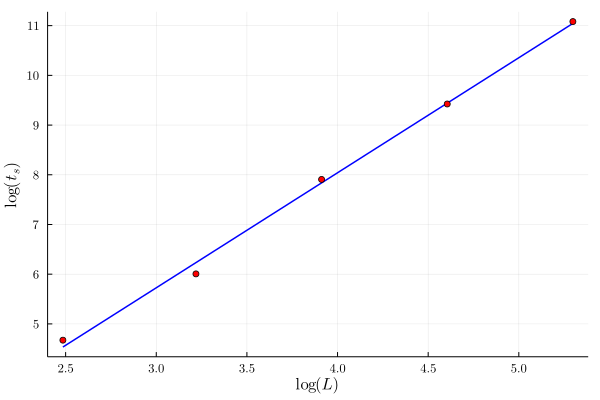

In [128]:
p = plot(x -> z * x + coeffz, lslog[1], lslog[end], color=:blue, lw=1.5, legend=false,
    xlabel=L"\mathrm{log}(L)", ylabel=L"\mathrm{log}(t_s)", fontfamily="Computer Modern")
scatter!(p, lslog, tslog, color=:red)

savefig(p, figpath * "bd-sat-z.pdf")
display(p)

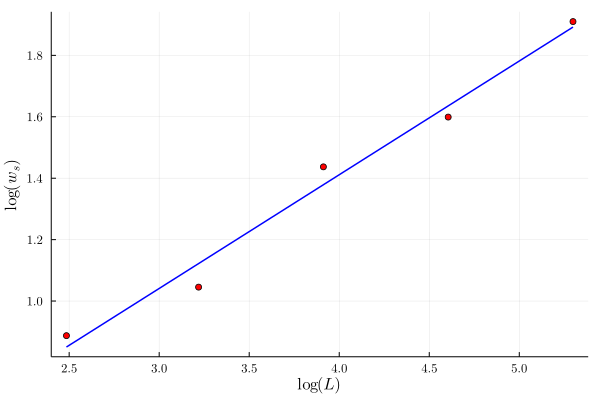

In [129]:
p = plot(x -> alpha * x + coeffa, lslog[1], lslog[end], color=:blue, lw=1.5, legend=false,
    xlabel=L"\mathrm{log}(L)", ylabel=L"\mathrm{log}(w_s)", fontfamily="Computer Modern")
scatter!(p, lslog, wslog, color=:red)

savefig(p, figpath * "bd-sat-alpha.pdf")
display(p)

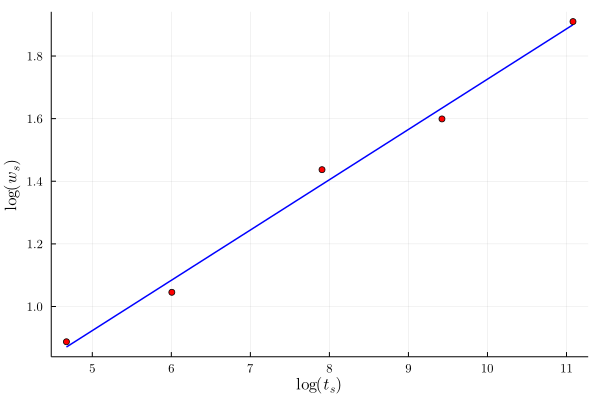

In [130]:
p = plot(x -> betanew * x + coeffb, tslog[1], tslog[end], color=:blue, lw=1.5, legend=false,
    xlabel=L"\mathrm{log}(t_s)", ylabel=L"\mathrm{log}(w_s)", fontfamily="Computer Modern")
scatter!(p, tslog, wslog, color=:red)

savefig(p, figpath * "bd-sat-beta.pdf")
display(p)